# Fraud Detection Analysis with Machine Learning

In the world of finance and banking, fraud is a major issue that results in significant loss and damage. With the advancement of technology, fraudulent transactions have become more complex and harder to spot. The traditional rules-based systems are no longer sufficient to detect these sophisticated fraudulent activities.

This Jupyter notebook presents a data science project that focuses on detecting fraudulent transactions using machine learning techniques. The project will explore, analyze, and model a dataset containing transactions, with the ultimate goal of creating a predictive model that can identify potential fraudulent activities. This notebook also includes additional steps such as data cleaning, feature engineering, model training and evaluation, and conclusion.

# **1.Introduction**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display
from collections import Counter


### Loading the dataset

In [2]:
data  = pd.read_csv("../input/fraud-insaid/Fraud.csv")
data.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

In [3]:
data["type"].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

### Checking the statistical values of numerical features

In [4]:
data.describe()

step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
50%      1.327057e+05    2.146614e+05  0.000000e+00    0.000000e+00  
75%      9.430367e+05    1.111909e+06  0.000000e+00    0.000000e+00  
max      3.560159e+08    3.561793e+08  1.000000e+00    1.000000e+00

### Checking the number of records and feautres present in the data

In [5]:
print("Number of records:",data.shape[0])


Number of records: 6362620


In [6]:
print("Number of features:",data.shape[1]-1) #exclude with 1 because one column is our target

Number of features: 10


In [7]:
nonfrauds, frauds = data.groupby('isFraud').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

Number of frauds:  8213
Number of non-frauds:  6354407
Percentage of fradulent data: 0.12908204481801522


In [8]:
#splitting the target and features
feature = data.drop(["isFraud"],axis = 1)
target = data.isFraud

# **2. Data Wrangling**

#### Removing unwanted data

In [9]:
feature.drop(["nameOrig",'nameDest'],axis = 1, inplace = True)

In [10]:
data.drop(["nameOrig",'nameDest'],axis = 1, inplace = True)

#### Dealing with missing values

In [11]:
def null_value(df):
    percentage = ((df.isna().sum()/df.isna().count())*100).sort_values(ascending = True)
    count = (df.isna().sum()).sort_values(ascending = True)
    diff = pd.concat([count,percentage],axis = 1, keys=["Count","Percentage"])
    return diff

In [12]:
null_value(feature)

Count  Percentage
step                0         0.0
type                0         0.0
amount              0         0.0
oldbalanceOrg       0         0.0
newbalanceOrig      0         0.0
oldbalanceDest      0         0.0
newbalanceDest      0         0.0
isFlaggedFraud      0         0.0

From the above calculation we can see that there is np null values.

#### Data Formatting

In [13]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFlaggedFraud  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 388.3+ MB


In [14]:
feature.rename(columns={"oldbalanceOrg": "Initial_balance(customer)",
                        "newbalanceOrig":"New_Balance(customer)",
                        "oldbalanceDest":"Initial_balance(receiver)","newbalanceDest":"New_Balance(receiver)"},inplace = True)

In [15]:
data.rename(columns={"oldbalanceOrg": "Initial_balance(customer)",
                        "newbalanceOrig":"New_Balance(customer)",
                        "oldbalanceDest":"Initial_balance(receiver)","newbalanceDest":"New_Balance(receiver)"},inplace = True)

# **3. Exploring Data Analysis**

#### Counting values of 0's and 1's from target 

(0.0, 80000.0)

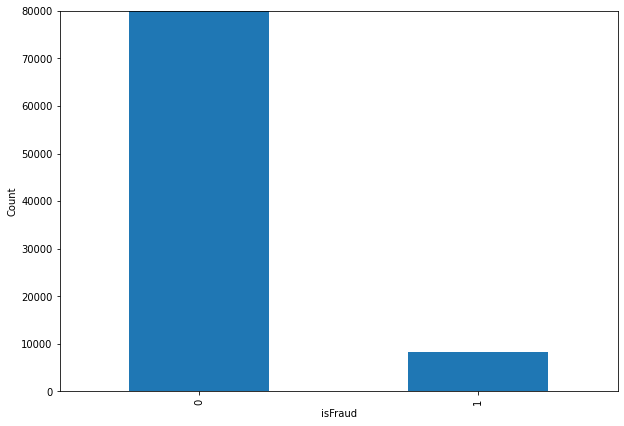

In [16]:
dd = target.value_counts()
dd.plot(kind = "bar",figsize = (10,7))
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.ylim(0,80000)

Each record is classified as normal(class "0") or fraudulent(class "1") and the transaction are heavily skewed towards normal. <br> The dataset is highly unbalance, where the positivr class(fraud) aacount for 0.12% of all transactions.


#### Analysing in how many processes(i.e. type) the fraudulent agents trying to empty the balance

In [17]:
fraud = data[data["isFraud"] == 1]
fraud.groupby(by = "type").aggregate({"isFraud":len})

isFraud
type             
CASH_OUT     4116
TRANSFER     4097

Above output insure that the fraud only happen during the *Cash out* and *transfer*

So from this conclusion we can say that, there would never be any fraud during other process(PAYMENT,DEBIT,CASH_IN). <br>
**Note:This is conclude from the current data, there can be exception in further detection **

In [18]:
#removing other type which is not useful
feature.drop(feature[feature["type"] == "PAYMENT"].index,inplace = True)
feature.drop(feature[feature["type"] == "DEBIT"].index,inplace = True)
feature.drop(feature[feature["type"] == "CASH_IN"].index,inplace = True)

In [19]:
print("Records after removing types record:",data.shape[0] - feature.shape[0])

Records after removing types record: 3592211


In [20]:
#same process from the main data
data.drop(data[data["type"] == "PAYMENT"].index,inplace = True)
data.drop(data[data["type"] == "DEBIT"].index,inplace = True)
data.drop(data[data["type"] == "CASH_IN"].index,inplace = True)

#### Outlier detection and treatment

In [21]:
feature_cat = feature["type"]
feature_num = feature.drop("type",axis = 1)

In [22]:
def outlier(df,ft):
    Q1 = df[ft].quantile(0.25)
    Q3 = df[ft].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    
    lst = df.index[(df[ft] < lower_bound) | (df[ft] > upper_bound)]
    if len(lst) != 0:
        print("Outlier detect",col)
    
    mean = df[ft].mean()
    for index in lst:
        df[ft].loc[index] = mean
    
    return lst
    

In [23]:
feature_num = feature_num.iloc[:,1:-1]
indx_lst = []
for col in feature_num.columns:
    indx_lst.extend(outlier(feature_num, col))
print("Treatment completed")

Outlier detect amount
Outlier detect Initial_balance(customer)
Outlier detect New_Balance(customer)
Outlier detect Initial_balance(receiver)
Outlier detect New_Balance(receiver)
Treatment completed


In [24]:
#outlier present in data(index)
print("Total outlier in the overall data(indexes):",len(set(indx_lst)))

Total outlier in the overall data(indexes): 856319


Updating the main data with outlier treat data

In [25]:
for col in feature_num.columns:
    data[col] = feature_num[col]
print("Updated!")

Updated!


#### Correlation

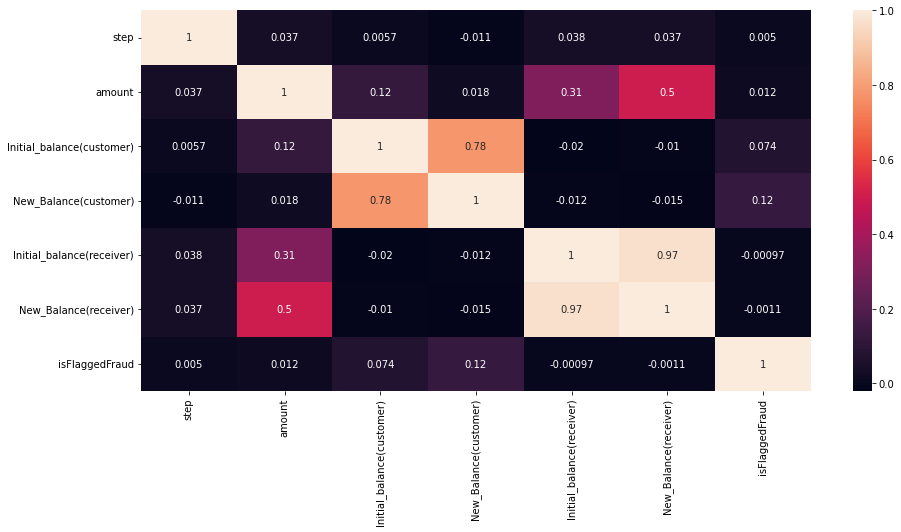

In [26]:
plt.figure(figsize = (15,7))
sns.heatmap(feature.corr(),annot = True)
plt.show()

# **4. Model Developement**

#### Label Encoding

In [27]:
data["type"].replace({"CASH_OUT":0,"TRANSFER": 1},inplace = True)
print("Encoded!")


Encoded!


#### Dealing with Unbalance data

Using Undersampling(Random sampleer):we reduce the number of samples from the majority class to match the number of samples in the minority class.

In [28]:
from imblearn import under_sampling
from imblearn.over_sampling import SMOTE
print("loaded!")

loaded!


Splitting data in features and target

In [29]:
X = data.drop(["step","isFraud"],axis = 1)
y = data.isFraud

In [30]:
#under sampling object creation
sm = SMOTE(random_state=42)

In [31]:
X_res, y_res = sm.fit_resample(X, y)

In [32]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 2762196, 0: 2762196})


#### Training and testing the data

In [33]:
#importing library
from sklearn.model_selection import train_test_split

In [34]:
X_train,X_test, y_train, y_test = train_test_split(X_res,y_res,train_size = 0.7)

Importing algorithm

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
print("Imported!")

Imported!


In [36]:
lrc = LogisticRegression(solver="liblinear", penalty = "l1")


In [37]:
clfs = {
    'LR': lrc,
}

In [38]:
def train_classifier(clf, X_train,Y_train,x_test,y_test):
    clf.fit(X_train,Y_train)
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test, y_pred)
    
    return accuracy, precision

In [39]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf,X_train,y_train,X_test,y_test)
    print("Classifier Name:",name)
    
    print("Accuracy:", current_accuracy)
    print("Precision:",current_precision)
    print()
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

Classifier Name: LR
Accuracy: 0.8702131998807712
Precision: 0.8496066677980116



In [40]:
performance_df = pd.DataFrame({"Algorithm":clfs.keys(),"Accuracy":accuracy_scores,"Precision":precision_scores})

In [41]:
performance_df

Algorithm  Accuracy  Precision
0        LR  0.870213   0.849607